In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import sys
from torchvision.utils import save_image
from PIL import Image, ImageOps
from pathlib import Path

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def style_loader(image_name, image_shape):
    image = Image.open(image_name)
    image = ImageOps.fit(image, image_shape, Image.ANTIALIAS)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [6]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [9]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [10]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [23]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img,
                       num_steps=1000, style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    bestLoss = [sys.float_info.max]
    bestImg = input_img.clone().detach()

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            totalLoss = style_score.item()+content_score.item()
            if totalLoss < bestLoss[0]:
                bestLoss[0] = totalLoss
                bestImg = input_img.clone().detach()
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f} Best Loss : {:4f}'.format(
                    style_score.item(), content_score.item(), bestLoss[0]))
                print()
                print(input_img)
                print(bestImg)

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    bestImg.data.clamp_(0, 1)

    return bestImg

In [24]:
def genImg(content_path, style_path, whiteNoise=False):
    content_img = image_loader(content_path)
    style_img = style_loader(style_path, (content_img.size()[3], content_img.size()[2]))
    input_img = content_img.clone()

    # assert style_img.size() == content_img.size(), \
    #    "we need to import style and content images of the same size"

    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')   
    
    if whiteNoise:
        input_img = torch.randn(content_img.data.size(), device=device)
        plt.figure()
        imshow(input_img, title='Input Image')
        
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

    plt.figure()
    imshow(output, title='Output Image')

    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()

    content_name = Path(content_path).stem
    style_name = Path(style_path).stem
    save_image(output, 'output_' + content_name + '&&' + style_name + '.jpg')

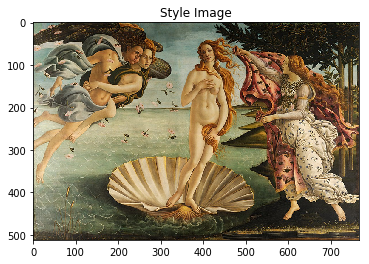

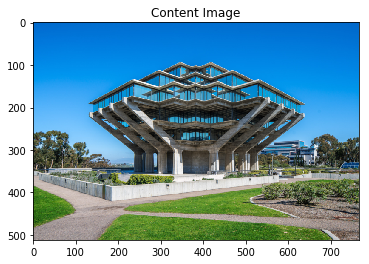

Building the style transfer model..


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 21.267723 Content Loss: 24.347109 Best Loss : 45.614832

run [100]:
Style Loss : 7.490497 Content Loss: 20.480793 Best Loss : 27.971290

run [150]:
Style Loss : 4.942353 Content Loss: 16.476454 Best Loss : 21.389508

run [200]:
Style Loss : 3.559036 Content Loss: 14.378335 Best Loss : 17.937371

run [250]:
Style Loss : 2.801045 Content Loss: 13.125313 Best Loss : 15.926358

run [300]:
Style Loss : 2.336052 Content Loss: 12.461238 Best Loss : 14.797290

run [350]:
Style Loss : 2.095206 Content Loss: 11.962269 Best Loss : 14.030911

run [400]:
Style Loss : 2.096764 Content Loss: 11.672334 Best Loss : 13.505613

run [450]:
Style Loss : 6.751789 Content Loss: 11.662793 Best Loss : 13.051122

run [500]:
Style Loss : 1.474331 Content Loss: 11.281156 Best Loss : 12.725157

run [550]:
Style Loss : 1.321257 Content Loss: 11.157678 Best Loss : 12.458988

run [600]:
Style Loss : 1.284353 Content Loss: 11.082305 Best Loss : 12.272408

run [650]:
Style Loss : 1.1

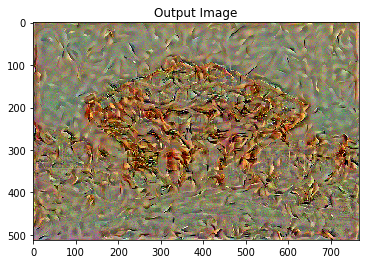

In [13]:
genImg("./Geisel_Library.jpg", "./The_Birth_of_Venus.jpg")

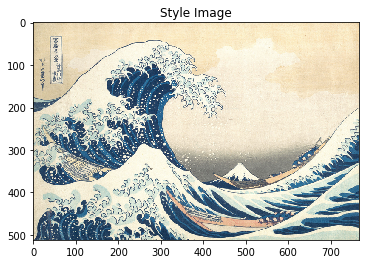

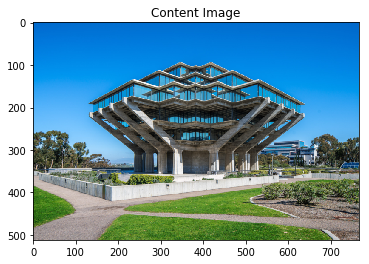

Building the style transfer model..


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 307.303864 Content Loss: 29.528276 Best Loss : 336.832140

run [100]:
Style Loss : 181.565201 Content Loss: 31.753111 Best Loss : 213.318312

run [150]:
Style Loss : 134.047226 Content Loss: 32.906429 Best Loss : 165.770683

run [200]:
Style Loss : 140.118912 Content Loss: 33.375351 Best Loss : 132.744122

run [250]:
Style Loss : 74.762291 Content Loss: 34.125175 Best Loss : 108.430008

run [300]:
Style Loss : 147354.843750 Content Loss: 70.201103 Best Loss : 99.005783

run [350]:
Style Loss : 392.688843 Content Loss: 51.418327 Best Loss : 99.005783

run [400]:
Style Loss : 156.096207 Content Loss: 49.120987 Best Loss : 99.005783

run [450]:
Style Loss : 82.654762 Content Loss: 46.533905 Best Loss : 99.005783

run [500]:
Style Loss : 45.464222 Content Loss: 44.084080 Best Loss : 86.197895

run [550]:
Style Loss : 19.619642 Content Loss: 41.800888 Best Loss : 61.420530

run [600]:
Style Loss : 2313020.500000 Content Loss: 165.077057 Best Loss : 60.894

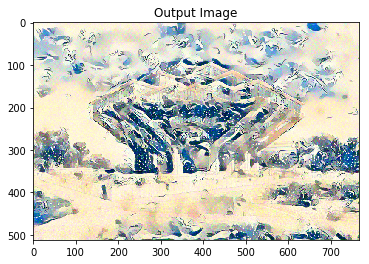

In [16]:
genImg("./Geisel_Library.jpg", "./Tsunami_by_hokusai.jpg")

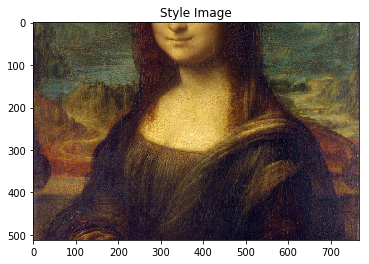

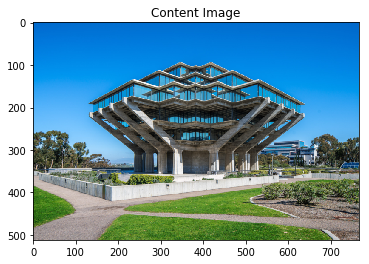

Building the style transfer model..


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 61.238628 Content Loss: 22.452559 Best Loss : 83.691187

run [100]:
Style Loss : 30.906151 Content Loss: 18.352345 Best Loss : 49.258495

run [150]:
Style Loss : 19.137966 Content Loss: 15.578390 Best Loss : 34.112638

run [200]:
Style Loss : 11.854240 Content Loss: 13.436588 Best Loss : 25.290829

run [250]:
Style Loss : 7.855890 Content Loss: 11.956919 Best Loss : 19.812809

run [300]:
Style Loss : 5.096005 Content Loss: 11.196391 Best Loss : 16.292397

run [350]:
Style Loss : 3.091827 Content Loss: 10.618754 Best Loss : 13.710582

run [400]:
Style Loss : 1.839333 Content Loss: 10.173059 Best Loss : 12.012391

run [450]:
Style Loss : 1.172869 Content Loss: 9.841319 Best Loss : 11.014189

run [500]:
Style Loss : 0.863854 Content Loss: 9.547352 Best Loss : 10.411206

run [550]:
Style Loss : 0.734886 Content Loss: 9.316003 Best Loss : 10.050888

run [600]:
Style Loss : 0.673236 Content Loss: 9.150695 Best Loss : 9.823930

run [650]:
Style Loss : 0.642

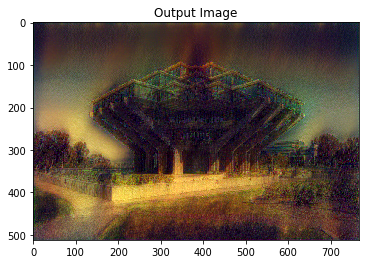

In [15]:
genImg("./Geisel_Library.jpg", "./Mona_Lisa.jpg")